In [9]:
import numpy as np
from scipy.optimize import root_scalar
from scipy.optimize import brentq
import matplotlib.pyplot as plt

# Functions

In [27]:
#parameters
t_1 = 0.425
t_2 = 0.05
t_3 = -0.025
t_4 = -0.075
kB = 8.617e-5
T=0.1
beta=1/(kB*T)

# k-grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)



In [11]:
def epsilon(k_x,k_y,t_1,t_2,t_3,mu):
    return -2*t_2*(np.cos(k_x)+np.cos(k_y))-4*t_3*np.cos(k_x)*np.cos(k_y)-mu

def tx(k_x,k_y,t_1,epsi):
    return -4*t_1*np.exp(-1j*(k_x/2+k_y/2))*(np.cos(k_x/2)*np.cos(k_y/2)-epsi*np.sin(k_x/2)*np.sin(k_y/2))

def tz(k_x,k_y,t_4):
    return 4*t_4*np.sin(k_x)*np.sin(k_y)

In [12]:
def dispersion(k_x,k_y,sigma,N_A,N_B,U,mu,beta,epsi):
    return epsilon(k_x,k_y,t_1,t_2,t_3,mu)-U/4*sigma*(N_A+N_B)+beta*np.sqrt(np.abs(tx(k_x,k_y,t_1,epsi))**2+(tz(k_x,k_y,t_4)-U/4*sigma*(N_A-N_B))**2)

def fermi(E, T, mu=0):
    if T == 0:
        return np.where(E < mu, 1.0, 0.0)
    else:
        x = (E ) / (kB * T)
        x = np.clip(x, -700, 700)
        return 1/ (np.exp(x) + 1)

def energy_split(k_x,k_y,N_A,N_B,U,mu,epsi):
    E_up_plus=dispersion(k_x,k_y,1,N_A,N_B,U,mu,1,epsi)
    E_up_minus=dispersion(k_x,k_y,1,N_A,N_B,U,mu,-1,epsi)
    E_down_plus=dispersion(k_x,k_y,-1,N_A,N_B,U,mu,1,epsi)
    E_down_minus=dispersion(k_x,k_y,-1,N_A,N_B,U,mu,-1,epsi)
    return E_up_plus,E_up_minus,E_down_plus,E_down_minus

In [13]:
#eigenvectors

def a(sigma, N_A,N_B, U,epsi):
    return 1/np.sqrt(2)*np.sqrt(1+(tz(KX,KY,t_4)-U/4*sigma*(N_A-N_B))/np.sqrt(np.abs(tx(KX,KY,t_1,epsi))**2+(tz(KX,KY,t_4)-U/4*sigma*(N_A-N_B))**2))

def b(sigma, N_A,N_B, U,epsi):
    return -1/np.sqrt(2)*np.sqrt(1-(tz(KX,KY,t_4)-U/4*sigma*(N_A-N_B))/np.sqrt(np.abs(tx(KX,KY,t_1,epsi))**2+(tz(KX,KY,t_4)-U/4*sigma*(N_A-N_B))**2))

In [14]:
#lattice site A

def n_e(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(a(1, N_A,N_B, U,epsi)**2*f_up_plus+a(-1, N_A,N_B, U,epsi)**2 *f_down_plus+b(1, N_A,N_B, U,epsi)**2*f_up_minus+b(-1, N_A,N_B, U,epsi)**2*f_down_minus)

def density_difference(mu, N_A,N_B, U, n_target, T,epsi):
    n = n_e(N_A,N_B, U, mu, T,epsi)
    return n - n_target

def order_param(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(a(1, N_A,N_B, U,epsi)**2*f_up_plus-a(-1, N_A,N_B, U,epsi)**2 *f_down_plus+b(1, N_A,N_B, U,epsi)**2*f_up_minus-b(-1, N_A,N_B, U,epsi)**2*f_down_minus)

def n_up(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(a(1, N_A,N_B, U,epsi)**2*f_up_plus+b(1, N_A,N_B, U,epsi)**2*f_up_minus)

def n_down(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(a(-1, N_A,N_B, U,epsi)**2 *f_down_plus+b(-1, N_A,N_B, U,epsi)**2*f_down_minus)

In [15]:
#lattice site B

def n_e2(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(b(1, N_A,N_B, U,epsi)**2*f_up_plus+b(-1, N_A,N_B, U,epsi)**2 *f_down_plus+a(1, N_A,N_B, U,epsi)**2*f_up_minus+a(-1, N_A,N_B, U,epsi)**2*f_down_minus)

def density_difference2(mu, N_A,N_B, U, n_target, T,epsi):
    n = n_e2(N_A,N_B, U, mu, T,epsi)
    return n - n_target

def order_param2(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(b(1, N_A,N_B, U,epsi)**2*f_up_plus-b(-1, N_A,N_B, U,epsi)**2 *f_down_plus+a(1, N_A,N_B, U,epsi)**2*f_up_minus-a(-1, N_A,N_B, U,epsi)**2*f_down_minus)

def n_up2(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(b(1, N_A,N_B, U,epsi)**2*f_up_plus+a(1, N_A,N_B, U,epsi)**2*f_up_minus)

def n_down2(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    f_up_plus = fermi(E_up_plus, T)
    f_up_minus = fermi(E_up_minus, T)
    f_down_plus = fermi(E_down_plus, T)
    f_down_minus = fermi(E_down_minus, T)
    return 1/n_k**2 * np.sum(b(-1, N_A,N_B, U,epsi)**2 *f_down_plus+a(-1, N_A,N_B, U,epsi)**2*f_down_minus)

In [16]:
#total density difference

def density_difference_total(mu, N_A, N_B, U, n_target, T, epsi):
    n_A = n_e(N_A, N_B, U, mu, T, epsi)
    n_B = n_e2(N_A, N_B, U, mu, T, epsi)
    return ((n_A + n_B) / 2) - n_target


# Self consistent starting condition

In [13]:
#k grid
n_k = 150
kx = np.linspace(-np.pi, np.pi, n_k)
ky = np.linspace(-np.pi, np.pi, n_k)
KX, KY = np.meshgrid(kx, ky)

# Initial values
eps=0
x = 0

U = 3
N_A_current = 0.4
N_B_current = -0.4

#starting mu
n_0=1
N_0=0
U_0=1


try:
    mu_0 = brentq(density_difference_total, -10, 10, args=(N_0,-N_0 ,U_0, n_0, T,eps), xtol=1e-5)
except ValueError:
    print("mu not found")

print(mu_0)
mu_current = mu_0



for i in range(1000):
    # Compute updated order parameters
    N_A_new = x * N_A_current + (1 - x) * order_param(N_A_current, N_B_current, U, mu_current, T,eps)
    N_B_new = x * N_B_current + (1 - x) * order_param2(N_A_current, N_B_current, U, mu_current, T,eps)

    # Update mu to maintain total density ~1
    try:
        mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
        break

    # Check total density
    n_new_A = n_e(N_A_new, N_B_new, U, mu_new, T, eps)
    n_new_B = n_e2(N_A_new, N_B_new, U, mu_new, T, eps)
    n_total = (n_new_A + n_new_B) / 2

    #print(f"step {i+1}: N_A = {N_A_new:.3f}, N_B = {N_B_new:.3f}, μ = {mu_new:.3f}, n = {n_total:.3f}")

    # Check convergence
    if (np.abs(N_A_new - N_A_current) +
        np.abs(N_B_new - N_B_current) +
        np.abs(n_total - n_0)) < 1e-5:
        print(f"✅ Converged in {i+1} steps.")
        break

    # Update for next step
    N_A_current = N_A_new
    N_B_current = N_B_new
    mu_current = mu_new


print("\n📌 Final self-consistent results:")
print(f"N_A = {N_A_current:.6f}")
print(f"N_B = {N_B_current:.6f}")
print(f"μ   = {mu_current:.6f}")
print(f"n   = {(n_e(N_A_current, N_B_current, U, mu_current, T,eps) + n_e2(N_A_current, N_B_current, U, mu_current, T,eps)) / 2:.6f}")
print(f"N_A + N_B = {N_A_current + N_B_current:.6e}")

0.12798745079306958
✅ Converged in 9 steps.

📌 Final self-consistent results:
N_A = 0.866006
N_B = -0.866006
μ   = 1.198803
n   = 1.000000
N_A + N_B = 0.000000e+00


# Runge Kutta Method 1

In [3]:
#derivative of order parameters with respect to chemical potential
#the dispersion depends on the chemical potential, so we need the derivative of the fermi function

   
def fermi_derivative(E, T):
    beta=1/(kB*T)
    f = 0.5 * (1 - np.tanh(0.5 * beta * E))
    return -beta * f * (1 - f)


#derivative of order parameters w.r.t. mu
def order_param_derivative(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    df_up_plus = fermi_derivative(E_up_plus, T)
    df_up_minus = fermi_derivative(E_up_minus, T)
    df_down_plus = fermi_derivative(E_down_plus, T)
    df_down_minus = fermi_derivative(E_down_minus, T)
    return 1/n_k**2 * np.sum(a(1, N_A,N_B, U,epsi)**2*df_up_plus-a(-1, N_A,N_B, U,epsi)**2 *df_down_plus+b(1, N_A,N_B, U,epsi)**2*df_up_minus-b(-1, N_A,N_B, U,epsi)**2*df_down_minus)

def order_param2_derivative(N_A,N_B,U,mu,T,epsi):
    E_up_plus,E_up_minus,E_down_plus,E_down_minus = energy_split(KX, KY, N_A,N_B, U, mu,epsi)
    df_up_plus = fermi_derivative(E_up_plus, T)
    df_up_minus = fermi_derivative(E_up_minus, T)
    df_down_plus = fermi_derivative(E_down_plus, T)
    df_down_minus = fermi_derivative(E_down_minus, T)
    return 1/n_k**2 * np.sum(b(1, N_A,N_B, U,epsi)**2*df_up_plus-b(-1, N_A,N_B, U,epsi)**2 *df_down_plus+a(1, N_A,N_B, U,epsi)**2*df_up_minus-a(-1, N_A,N_B, U,epsi)**2*df_down_minus)

def find_mu(N_A_new,N_B_new,U,n_0,T,eps):
    try:
        mu_new = brentq(density_difference_total, -10, 10, args=(N_A_new, N_B_new, U, n_0, T,eps), xtol=1e-5)
    except ValueError:
        print("mu not found")
    return mu_new

def mu_derivative(m1,m2,dt):
    return (m2-m1)/dt

In [16]:
#Runge Kutta

def N_new(NA,NB,U,mu,T,eps,dt):
    mu1=find_mu(NA,NB,U,n_0,T,eps)
    k1=np.array([order_param_derivative(NA,NB,U,mu1,T,eps)*mu_derivative(mu,mu1,dt),order_param2_derivative(NA,NB,U,mu1,T,eps)*mu_derivative(mu,mu1,dt)])

    mu2=find_mu(NA+dt/2*k1[0],NB+dt/2*k1[1],U,n_0,T,eps)
    k2=np.array([order_param_derivative(NA+dt/2*k1[0],NB+dt/2*k1[1],U,mu2,T,eps)*mu_derivative(mu1,mu2,dt),order_param2_derivative(NA+dt/2*k1[0],NB+dt/2*k1[1],U,mu2,T,eps)*mu_derivative(mu1,mu2,dt)])

    mu3=find_mu(NA+dt/2*k2[0],NB*dt/2*k2[1],U,n_0,T,eps)
    k3=np.array([order_param_derivative(NA+dt/2*k2[0],NB+dt/2*k2[1],U,mu3,T,eps)*mu_derivative(mu2,mu3,dt),order_param2_derivative(NA+dt/2*k2[0],NB+dt/2*k2[1],U,mu3,T,eps)*mu_derivative(mu2,mu3,dt)])

    mu4=find_mu(NA+dt*k3[0],NB+dt*k3[1],U,n_0,T,eps)
    k4=np.array([order_param_derivative(NA+dt*k3[0],NB+dt*k3[1],U,mu4,T,eps)*mu_derivative(mu3,mu4,dt),order_param2_derivative(NA+dt*k3[0],NB+dt*k3[1],U,mu4,T,eps)*mu_derivative(mu3,mu4,dt)])
    return np.array([NA,NB])+dt/6*(k1+2*k2+2*k3+k4),mu4



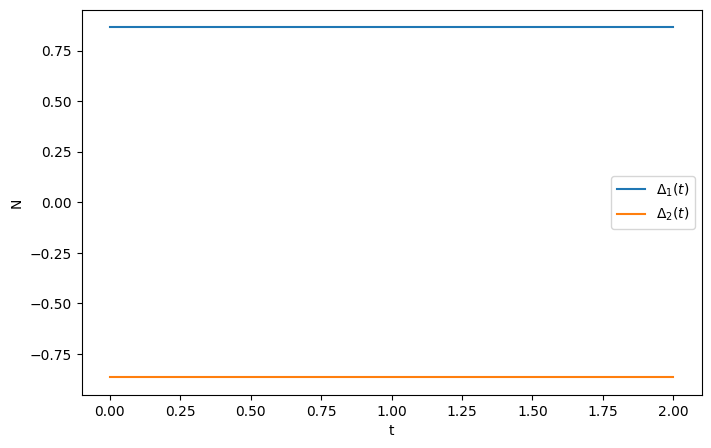

In [14]:
N_A0 = 0.866006
N_B0 = -0.866006
mu0   = 1.198803
U=3
epsi=0.05
n_0=1

dt = 0.1              # time step
t_max = 2.0
times = np.arange(0, t_max, dt)
n_steps = int(t_max/dt)

# Initialize arrays to store results
Delta1 = np.zeros(n_steps+1)
Delta2 = np.zeros(n_steps+1)
mu = np.zeros(n_steps+1)
time = np.zeros(n_steps+1)

# Initial conditions
Delta1[0] = N_A0
Delta2[0] = N_B0
mu[0]=mu0

for n in range(n_steps):
    N,mu4=N_new(Delta1[n],Delta2[n],U,mu[n],T,epsi,dt)
    Delta1[n+1]=N[0]
    Delta2[n+1]=N[1]
    mu[n+1]=mu4
    time[n+1] = n*dt + dt



plt.figure(figsize=(8,5))
plt.plot(time, Delta1, label=r'$\Delta_1(t)$')
plt.plot(time, Delta2, label=r'$\Delta_2(t)$')
plt.xlabel('t')
plt.ylabel('N')
plt.legend()
plt.show()

In [15]:
find_mu(N_A0,N_B0,U,1,T,0.05)

1.1987942496633552

# Runge Kutta Method

In [64]:
N_A0 = 0.866006
N_B0 = -0.866006
mu0   = 1.198803
U=3
epsi=0.01
n_0=1


In [29]:
#pseudomagnetic field

def h_0(k_x,k_y,t_1,t_2,t_3,mu,U,sigma,n_A,n_B,N_A,N_B):
    return epsilon(k_x,k_y,t_1,t_2,t_3,mu)+U/4*(n_A+n_B-sigma*(N_A-N_B))

def h_x(k_x,k_y,t_1,epsi):
    return np.real(tx(k_x,k_y,t_1,epsi))

def h_y(k_x,k_y,t_1,epsi):
    return np.imag(tx(k_x,k_y,t_1,epsi))

def h_z(k_x,k_y,t_4,U,sigma,n_A,n_B,N_A,N_B):
    return tz(k_x,k_y,t_4)+U/4*(n_A-n_B-sigma*(N_A-N_B))

def h_vec(t_1,t_4,U,sigma,epsi,n_A,n_B,N_A,N_B):
    return np.array([h_x(KX,KY,t_1,epsi),h_y(KX,KY,t_1,epsi),h_z(KX,KY,t_4,U,sigma,n_A,n_B,N_A,N_B)])

def h_length(t_1,t_4,U,sigma,epsi,n_A,n_B,N_A,N_B):
    return np.linalg.norm(h_vec(t_1,t_4,U,sigma,epsi,n_A,n_B,N_A,N_B))

In [37]:
#order parameters

def rho_AA(S):
    return 1/2*(1+S[2])

def rho_BB(S):
    return 1/2*(1-S[2])


def nA_rho(S_up,S_down):
    return 1/n_k**2*np.sum(rho_AA(S_up)+rho_AA(S_down))


def nB_rho(S_up,S_down):
    return 1/n_k**2*np.sum(rho_BB(S_up)+rho_BB(S_down))

def NA_rho(S_up,S_down):
    return 1/n_k**2*np.sum(rho_AA(S_up)-rho_AA(S_down))


def NB_rho(S_up,S_down):
    return 1/n_k**2*np.sum(rho_BB(S_up)-rho_BB(S_down))


#initial state

def S_0_vec(t_1,t_4,sigma,U,epsi,n_A,n_B,N_A,N_B):
    x=beta*h_length(t_1,t_4,U,sigma,epsi,n_A,n_B,N_A,N_B)
    x=np.clip(x,-50,50)
    return np.tanh(x)*1/(h_length(t_1,t_4,U,sigma,epsi,n_A,n_B,N_A,N_B)+1e-12)*h_vec(t_1,t_4,U,sigma,epsi,n_A,n_B,N_A,N_B)



In [65]:
#RK4 stage
hbar=1.054e-34
def F(t_1,t_4,U,sigma,epsi,n_A,n_B,N_A,N_B,S_vec):
    return 2/hbar*np.cross(h_vec(t_1,t_4,U,sigma,epsi,n_A,n_B,N_A,N_B),S_vec,axis=0)

def rk4_step(S_up,S_down,n_A,n_B,N_A,N_B, dt):

    k1u, k1d = F(t_1,t_4,U,1,epsi,n_A,n_B,N_A,N_B,S_up),F(t_1,t_4,U,-1,epsi,n_A,n_B,N_A,N_B,S_down)
    k2u, k2d = F(t_1,t_4,U,1,epsi,n_A,n_B,N_A,N_B,S_up+ 0.5*dt*k1u),F(t_1,t_4,U,-1,epsi,n_A,n_B,N_A,N_B,S_down+ 0.5*dt*k1d)
   
    k3u, k3d = F(t_1,t_4,U,1,epsi,n_A,n_B,N_A,N_B,S_up+ 0.5*dt*k2u),F(t_1,t_4,U,-1,epsi,n_A,n_B,N_A,N_B,S_down+ 0.5*dt*k2d)

    k4u, k4d = F(t_1,t_4,U,1,epsi,n_A,n_B,N_A,N_B,S_up+ dt*k3u),F(t_1,t_4,U,-1,epsi,n_A,n_B,N_A,N_B,S_down+ dt*k3d)

    S_up_new = S_up + dt/6 * (k1u + 2*k2u + 2*k3u + k4u)
    S_dn_new = S_down + dt/6 * (k1d + 2*k2d + 2*k3d + k4d)

    return S_up_new, S_dn_new

def normalize_S(S):
    norm = np.linalg.norm(S, axis=0)
    return S / (norm + 1e-12)

def enforce_spin_length(S):
    length = np.linalg.norm(S, axis=0)
    return S / np.maximum(length, 1e-12)


In [66]:
#initial S
S_up_cur=S_0_vec(t_1,t_4,1,U,epsi,1,1,N_A0,N_B0)
S_down_cur=S_0_vec(t_1,t_4,-1,U,epsi,1,1,N_A0,N_B0)

dt = 0.00001
t_max = 0.01
n_steps = int(t_max/dt)

nA_t = np.zeros(n_steps+1)
nB_t = np.zeros(n_steps+1)

nA_t[0] = n_0
nB_t[0] = n_0

NA_t = np.zeros(n_steps+1)
NB_t = np.zeros(n_steps+1)

NA_t[0] = N_A0
NB_t[0] = N_B0

for n in range(n_steps):
    S_up_cur,S_down_cur=rk4_step(S_up_cur,S_down_cur,nA_t[n],nB_t[n],NA_t[n],NB_t[n],dt)
    S_up_cur,S_down_cur=normalize_S(S_up_cur),normalize_S(S_down_cur)
    S_up_cur,S_down_cur=enforce_spin_length(S_up_cur),enforce_spin_length(S_down_cur)
    nA_t[n+1]=nA_rho(S_up_cur,S_down_cur)
    nB_t[n+1]=nB_rho(S_up_cur,S_down_cur)
    NA_t[n+1]=NA_rho(S_up_cur,S_down_cur)
    NB_t[n+1]=NB_rho(S_up_cur,S_down_cur)

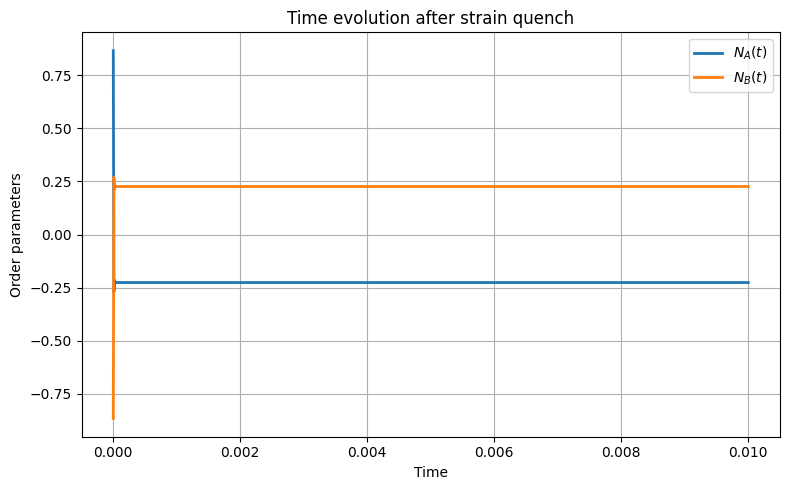

In [67]:
time = np.linspace(0, t_max, n_steps + 1)

plt.figure(figsize=(8, 5))

plt.plot(time, NA_t, label=r"$N_A(t)$", linewidth=2)
plt.plot(time, NB_t, label=r"$N_B(t)$", linewidth=2)

plt.xlabel("Time")
plt.ylabel("Order parameters")
plt.title("Time evolution after strain quench")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

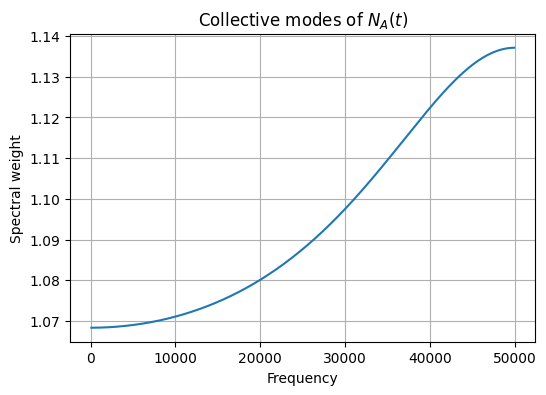

In [ ]:
freq = np.fft.fftfreq(len(time), d=dt)
spec = np.abs(np.fft.fft(NA_t - np.mean(NA_t)))

plt.figure(figsize=(6,4))
plt.plot(freq[freq > 0], spec[freq > 0])
plt.xlabel("Frequency")
plt.ylabel("Spectral weight")
plt.title("Collective modes of $N_A(t)$")
plt.grid(True)
plt.show()
